## MIR PROJECT


### TITLE:

A 5 year sales forecast of quarterly sales for Northwest, Northeast, Central, Southwest, Southeast, Canada, France, Germany, Australia, United Kingdom


### 1) THE DATASET

The dataset used for this project was retrived from AdventureWorks 2017. 


###### Some of the Python Libraries that will be needed for the sales forecasting


In [1]:
#work horses of tables (dataframe) and arrays
%matplotlib inline
import pyodbc 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DESKTOP-2NRFU9A;"
                      "Database=AdventureWorks2017;"
                      "Trusted_Connection=yes;")

##### Reading the dataset for Australia

In [4]:
#Importing southwest Data from SQL server
au = pd.read_sql_query(""" 
SELECT
A.[LineTotal]
,B.[OrderDate]
,CASE WHEN B.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel
FROM [Sales].[SalesOrderDetail] AS A
LEFT JOIN [Sales].[SalesOrderHeader] AS B
ON A.SalesOrderID = B.SalesOrderID
LEFT JOIN [Sales].[SalesTerritory] AS C
ON B.TerritoryID = C.TerritoryID
WHERE C.[Name] = 'Australia' 
""", cnxn)

In [5]:
#The head is printing the first 5 rows of the data set.
au.head()

,LineTotal,OrderDate,Sales_Channel
0,3399.99,2011-05-31,Online
1,3578.27,2011-06-01,Online
2,3374.99,2011-06-01,Online
3,3399.99,2011-06-01,Online
4,3578.27,2011-06-02,Online


In [32]:
#The tail is printing the last 5 rows of the data set.
au.tail()

,LineTotal,OrderDate,Sales_Channel
15053,3.99,2014-06-30,Online
15054,3.99,2014-06-30,Online
15055,32.60,2014-06-30,Online
15056,120.00,2014-06-30,Online
15057,7.95,2014-06-30,Online


In [6]:
#This is to check for missing values
au.isnull().sum()

LineTotal        0
OrderDate        0
Sales_Channel    0
dtype: int64

In [7]:
#This is to identify how many columns(25,644) and roles(3)
print('Shape of dataset:',au.shape)

Shape of dataset: (15058, 3)


In [8]:
#This describe the dataset at a glance to enable us build our machine learning
au.describe()

,LineTotal
count,15058.000000
mean,707.619601
std,1119.895724
min,2.290000
25%,8.990000
50%,35.000000
75%,1120.490000
max,17616.370044


##### Dataset Summary:

The dataset has 15,053 data points with 3 features(LineTotal, Orderdate, Sales_Channels)

To avoid overwritting the actual data, a new dataset will be created with the neccesary features of the data needed for this project.

In [9]:
#The set_index command is setting the column OrderDate as an Index
au = au.set_index(['OrderDate'])

In [10]:
#Summarise the transactions by order Quarter
# The 'QS' string groups the data in buckets by start of the quarter
y = au['LineTotal'].resample('QS').sum()

In [11]:
y.head()

OrderDate
2011-04-01    209652.9046
2011-07-01    614525.1848
2011-10-01    707978.2158
2012-01-01    632631.0294
2012-04-01    539001.9938
Freq: QS-JAN, Name: LineTotal, dtype: float64

In [12]:
y.tail()

OrderDate
2013-04-01    8.376137e+05
2013-07-01    1.308674e+06
2013-10-01    1.468487e+06
2014-01-01    1.634294e+06
2014-04-01    1.133438e+06
Freq: QS-JAN, Name: LineTotal, dtype: float64

In [13]:
#The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

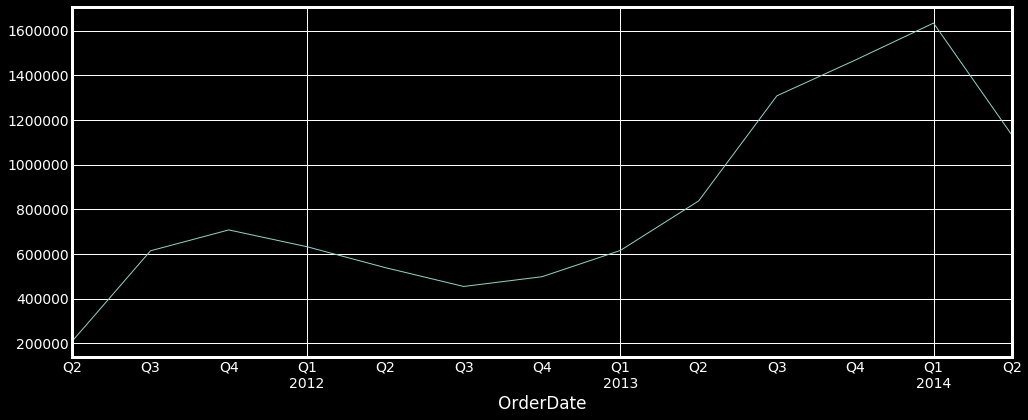

In [23]:
plt.style.use('dark_background')
y.plot(figsize=(15, 6))
plt.show()

Analyzing the chart, we can observe that the time-series has seasonality pattern. Q1 of 2014 has a peak of sales, at least for the last 3 quarters. There is an upward trend over the years as well.

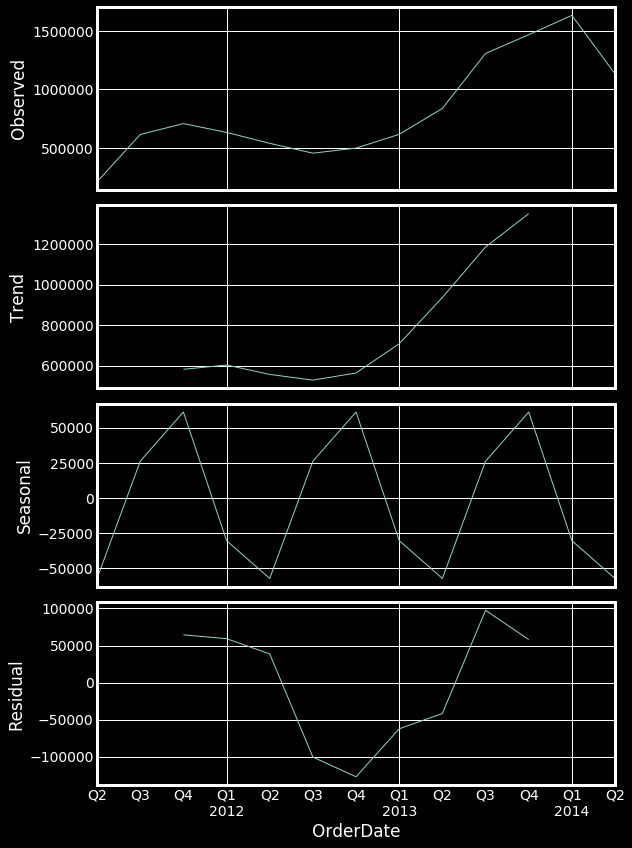

In [24]:
from matplotlib import rcParams
plt.style.use('dark_background')   
rcParams['figure.figsize'] = 9, 12
plt.rc('lines', linewidth=1, color='b')
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

### 2) PREPROCESSING

#### SARIMA Forecasting Model
Let’s use SARIMA, becasue the time-series has seasonality pattern. The models notation is SARIMA(p, d, q).(P,D,Q)m. These three parameters account for seasonality, trend, and noise in data

In [25]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:366.54206895086736
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-17.187973863531113
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:327.06373939298265
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:36.42965432215303
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:305.56344134934835
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:280.17920308314586
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:336.8185162099586
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:308.49083561586684
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:306.17837235403744
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:281.54933459594736


In [27]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(0, 1, 0, 12)12 model - AIC:2.0


In [28]:
# print statistics
print(res.aic)
print(res.summary())

336.56640318968346
                           Statespace Model Results                           
Dep. Variable:              LineTotal   No. Observations:                   13
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -165.283
Date:                Sat, 18 Jan 2020   AIC                            336.566
Time:                        18:20:17   BIC                            338.021
Sample:                    04-01-2011   HQIC                           336.028
                         - 04-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4136      1.585      0.261      0.794      -2.693       3.520
ma.L1          0.1089      2.060      0.053      0.958      -3.928       4.146
sigma2      5.831e+10   2.78e-11 

In [29]:
plt.style.use('fivethirtyeight')
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [30]:
# print statistics
print(results.aic)
print(results.summary())

2.0
                                 Statespace Model Results                                 
Dep. Variable:                          LineTotal   No. Observations:                   13
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   0.000
Date:                            Sat, 18 Jan 2020   AIC                              2.000
Time:                                    18:20:27   BIC                                nan
Sample:                                04-01-2011   HQIC                               nan
                                     - 04-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10         -0       -inf      0.000       1e-10       1e-10
Ljung-Box (Q):                 

###### The best model is P>|Z| as is all zeros

In [79]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
chi

142.13816003902645

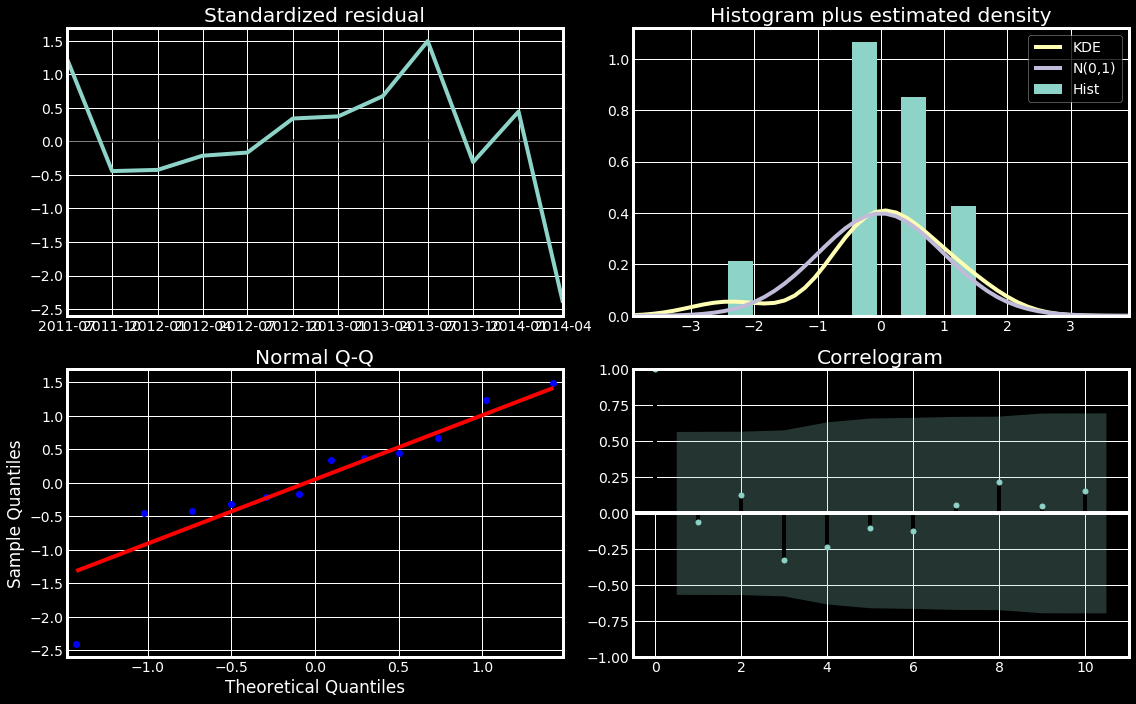

In [32]:
plt.style.use('dark_background')
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

##### Getting the Auto correlation

With the diagnostic above we can visualize important information as the distribution and the Auto correlation function ACF (correlogram). From "0" down to 3 demostrate strong correlation

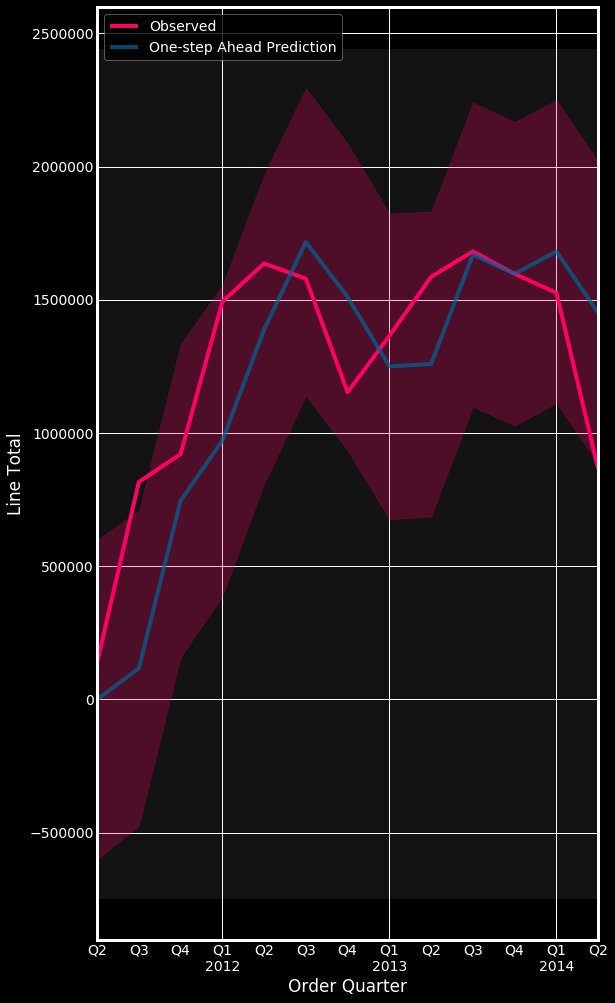

In [80]:
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2011-04-01'), 
                          end=pd.to_datetime('2014-04-01'),
                          dynamic=False)
pred_ci = pred.conf_int()
 
# plot in-sample-prediction
ax = y.plot(label='Observed',color='#ff0066');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#006699');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2011-04-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Order Quarter')
ax.set_ylabel('Line Total')
plt.legend(loc='upper left')
plt.style.use('dark_background')
plt.show()

### True Values Of Forecast

step above consists in comparing the true values with the forecast predictions. Our forecasts fit with the true values very well. The command “pred = res.get_prediction(start=pd.to_datetime(‘2011–04–01’)” determines the period which you would forecast in comparing with the true data.

In [34]:
y_forecasted = pred.predicted_mean
y_truth = y['2011-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 52922171388.4
The Root Mean Squared Error is 230048.19


### Observations:
In both MSE and RMSE, values closer to zero are better. They are a measure of accuracy.

## 3) Sales Forecast for the Next 5 Years

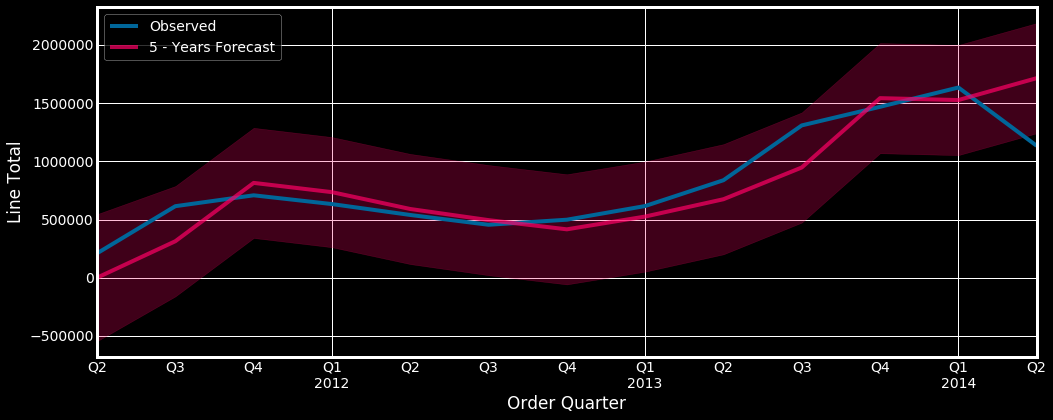

In [35]:
#pred.predicted_mean
# plot in-sample-prediction
ax = y.plot(label='Observed',color='#006699');
pred.predicted_mean.plot(figsize=(15, 6),label='5 - Years Forecast', alpha=.7, color='#ff0066')
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
#y.plot(figsize=(15, 6))
ax.set_xlabel('Order Quarter')
ax.set_ylabel('Line Total')
plt.legend(loc='upper left')
plt.style.use('dark_background')
plt.show()

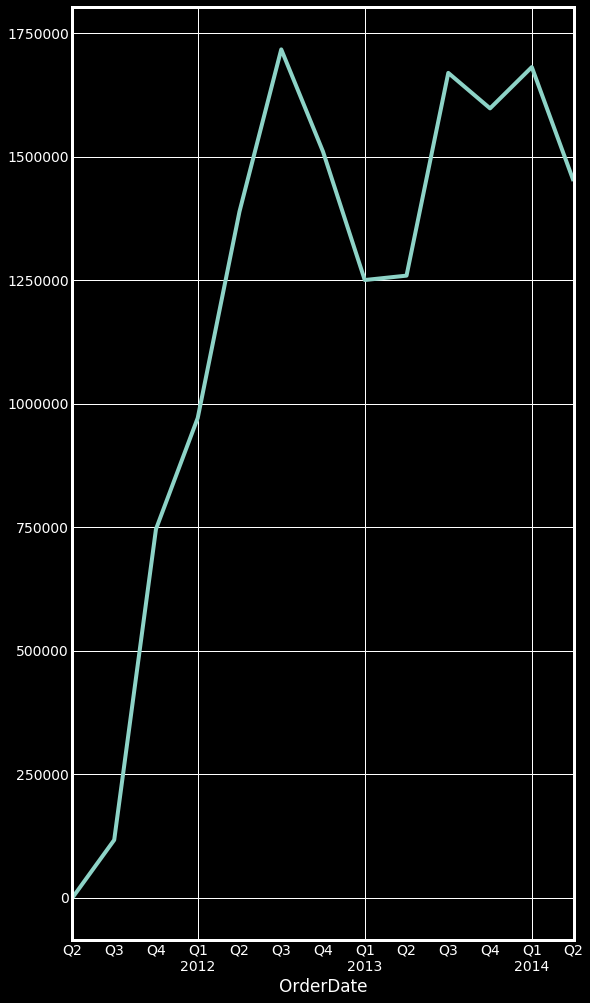

In [81]:
#Ploting the forecast
from matplotlib import rcParams
plt.style.use('dark_background')
forecast.plot()
rcParams['figure.figsize'] = 8, 16

In [82]:
#This step indicate the predicted values of the test I have ran before.
y_forecasted = pred.predicted_mean
y_forecasted.head(20).round(2)

OrderDate
2011-04-01          0.00
2011-07-01     116849.20
2011-10-01     745985.93
2012-01-01     970992.46
2012-04-01    1388802.30
2012-07-01    1716998.97
2012-10-01    1510076.23
2013-01-01    1250180.80
2013-04-01    1259071.65
2013-07-01    1669425.48
2013-10-01    1597629.46
2014-01-01    1681184.98
2014-04-01    1450598.59
Freq: QS-JAN, dtype: float64

#### Evalution

This step indicate the truth values of the data set. We can compare the two series above to measure the model accuracy.

In [45]:
y_truth.head(20).round(2)

OrderDate
2011-04-01     209652.90
2011-07-01     614525.18
2011-10-01     707978.22
2012-01-01     632631.03
2012-04-01     539001.99
2012-07-01     454775.12
2012-10-01     498375.04
2013-01-01     615889.63
2013-04-01     837613.71
2013-07-01    1308673.59
2013-10-01    1468487.39
2014-01-01    1634294.36
2014-04-01    1133437.79
Freq: QS-JAN, Name: LineTotal, dtype: float64

In [46]:
pred_ci.head(40).round(2)

,lower LineTotal,upper LineTotal
OrderDate,,
2011-04-01,-545685.37,545685.37
2011-07-01,-160436.50,787516.53
2011-10-01,341375.06,1287953.36
2012-01-01,261734.91,1208296.95
2012-04-01,117036.99,1063598.83
2012-07-01,21406.91,967968.75
2012-10-01,-57689.43,888872.41
2013-01-01,52141.72,998703.56
2013-04-01,201065.33,1147627.18


In the table above we can visualize the lower and upper values which the model indicate as boundaries for the forecasting.

In [48]:
forecast = pred.predicted_mean
forecast.head(20).round(2)

OrderDate
2011-04-01          0.00
2011-07-01     313540.01
2011-10-01     814664.21
2012-01-01     735015.93
2012-04-01     590317.91
2012-07-01     494687.83
2012-10-01     415591.49
2013-01-01     525422.64
2013-04-01     674346.26
2013-07-01     947100.11
2013-10-01    1542882.27
2014-01-01    1526488.70
2014-04-01    1714613.49
Freq: QS-JAN, dtype: float64

### Visualization of the Forecast

Finally here we have the quarterly sales forecasting for Australia for 5 years!

We can notice that the sales increase over the years . Second quarter of 2014 is the worst quaters.

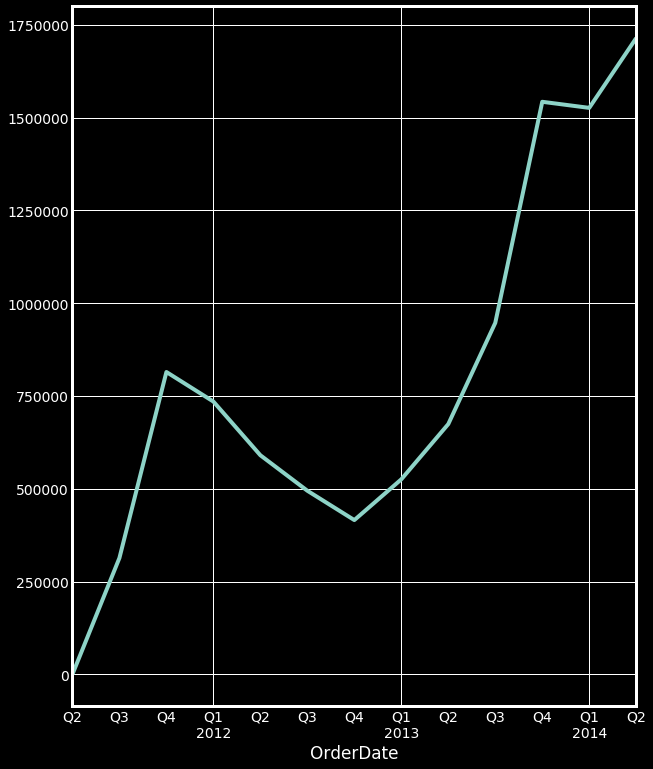

In [41]:
forecast.plot()
rcParams['figure.figsize'] = 18, 8